# STAT435 - HW2

### Instructor: Professor Bradly Stadie
### Due Date: Oct 21, Monday
### Office Hour (Young): Wednesday 1:30-2:30pm

In this homework, we will explore several policy gradient methods in multiple different environments. Also, there are two parts in this homework (Application and Theory). For application part, you will be doing some fun coding. For theory part, you will be doing some fun math to get some more flavor :D

## Application

## 1. Vanilla Policy Gradient

In this homework, we will use Vanilla Policy Gradient (VPG, or sometimes REINFORCE) to solve the lunar lander environment. Please do the following.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from tqdm import tqdm

1. Play around with the environment. Is there anything interesting about the environment?

In [11]:
# Set up the environment
env = gym.make("LunarLander-v3")
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
print(input_dim)
print(output_dim)

# print out some essential information about the environment
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Number of actions:", env.action_space.n)
print("Number of dimensions in observation space:", env.observation_space.shape[0])

# more details can be found in link: https://gymnasium.farama.org/environments/box2d/lunar_lander/

8
4
Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)
Number of actions: 4
Number of dimensions in observation space: 8


2. Implement a policy network with 3 layers with hidden size 128.

In [9]:
# Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return torch.softmax(x, dim=-1)  # Apply softmax to get probabilities

3. Implement a REINFORCE agent (Fill in the blank!)

In [7]:
# REINFORCE Agent
class REINFORCEAgent:
    def __init__(self, policy_network, learning_rate):
        self.policy_network = policy_network
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=learning_rate)
        
    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        probs = self.policy_network(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)
    
    def update(self, rewards, log_probs):
        returns = []
        G = 0

        for r in reversed(rewards): 
            G = r + G
            returns.insert(0, G)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        
        policy_loss = []
        for log_prob, R in zip(log_probs, returns):
            policy_loss.append(-log_prob * R)
        
        policy_loss = torch.stack(policy_loss).sum()
        
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

4. Complete the training loop (Fill in the blank!)

(optional: You can also add the accumulated reward to see less noisy learning curve) 

In [8]:
# In the training loop:
def train(num_episodes, max_steps):
    policy_network = PolicyNetwork(input_dim, output_dim)
    agent = REINFORCEAgent(policy_network, learning_rate=5e-4)
    
    episode_rewards = []
    
    for episode in tqdm(range(num_episodes)):
        state, _ = env.reset()
        episode_reward = 0
        log_probs = []
        rewards = []
        
        for step in range(max_steps):
            action, log_prob = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            
            log_probs.append(log_prob)
            rewards.append(reward)
            episode_reward += reward
            
            if done or truncated:
                break
            
            state = next_state
        
        episode_rewards.append(episode_reward)
        agent.update(rewards, log_probs)
        
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Average Reward: {np.mean(episode_rewards[-50:]):.2f}")
    
    return agent, episode_rewards

  3%|▎         | 103/3000 [00:03<01:45, 27.58it/s]

Episode 100, Average Reward: -207.94


  7%|▋         | 204/3000 [00:07<01:45, 26.52it/s]

Episode 200, Average Reward: -151.37


 10%|█         | 303/3000 [00:11<01:57, 22.88it/s]

Episode 300, Average Reward: -149.95


 13%|█▎        | 401/3000 [00:15<01:42, 25.35it/s]

Episode 400, Average Reward: -106.35


 17%|█▋        | 502/3000 [00:20<02:03, 20.23it/s]

Episode 500, Average Reward: -105.38


 20%|██        | 603/3000 [00:26<02:34, 15.54it/s]

Episode 600, Average Reward: -85.58


 23%|██▎       | 702/3000 [00:32<03:02, 12.57it/s]

Episode 700, Average Reward: -58.86


 27%|██▋       | 801/3000 [00:42<03:36, 10.18it/s]

Episode 800, Average Reward: -79.96


 30%|███       | 900/3000 [00:58<04:08,  8.45it/s]

Episode 900, Average Reward: -110.92


 33%|███▎      | 1001/3000 [01:15<05:11,  6.42it/s]

Episode 1000, Average Reward: -141.95


 37%|███▋      | 1103/3000 [01:28<02:27, 12.89it/s]

Episode 1100, Average Reward: -111.92


 40%|████      | 1200/3000 [01:43<04:18,  6.97it/s]

Episode 1200, Average Reward: -122.82


 43%|████▎     | 1303/3000 [01:55<01:52, 15.10it/s]

Episode 1300, Average Reward: -49.83


 47%|████▋     | 1401/3000 [02:05<02:03, 12.95it/s]

Episode 1400, Average Reward: -4.81


 50%|████▉     | 1499/3000 [02:18<04:30,  5.56it/s]

Episode 1500, Average Reward: -37.22


 53%|█████▎    | 1601/3000 [02:32<03:13,  7.23it/s]

Episode 1600, Average Reward: 14.05


 57%|█████▋    | 1702/3000 [02:52<03:03,  7.08it/s]

Episode 1700, Average Reward: 4.27


 60%|██████    | 1801/3000 [03:07<02:24,  8.28it/s]

Episode 1800, Average Reward: -84.33


 63%|██████▎   | 1902/3000 [03:23<01:40, 10.91it/s]

Episode 1900, Average Reward: 42.65


 67%|██████▋   | 2001/3000 [03:37<02:05,  7.99it/s]

Episode 2000, Average Reward: 23.43


 70%|███████   | 2101/3000 [03:57<03:50,  3.90it/s]

Episode 2100, Average Reward: 51.34


 73%|███████▎  | 2201/3000 [04:19<02:16,  5.83it/s]

Episode 2200, Average Reward: 48.16


 77%|███████▋  | 2300/3000 [04:44<03:25,  3.41it/s]

Episode 2300, Average Reward: 54.15


 80%|████████  | 2401/3000 [05:08<01:19,  7.51it/s]

Episode 2400, Average Reward: 40.54


 83%|████████▎ | 2501/3000 [05:30<00:55,  9.00it/s]

Episode 2500, Average Reward: 21.21


 87%|████████▋ | 2600/3000 [05:46<02:12,  3.03it/s]

Episode 2600, Average Reward: 62.75


 90%|█████████ | 2700/3000 [06:11<01:17,  3.87it/s]

Episode 2700, Average Reward: 70.31


 93%|█████████▎| 2800/3000 [06:37<00:28,  7.05it/s]

Episode 2800, Average Reward: 54.55


 97%|█████████▋| 2900/3000 [14:50<07:44,  4.65s/it]  

Episode 2900, Average Reward: 60.55


100%|██████████| 3000/3000 [15:11<00:00,  3.29it/s]


Episode 3000, Average Reward: 135.83


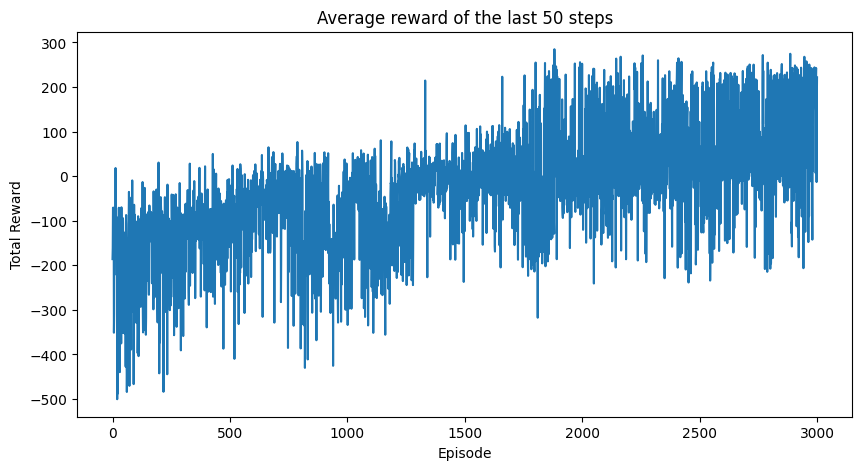

In [9]:
# Train the agent
num_episodes = 3000
max_steps = 1000
trained_agent, episode_rewards = train(num_episodes, max_steps)

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards)
plt.title("Average reward of the last 50 steps")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()


### Fun visualization! Do you think your agent does a good job?

In [25]:
def visualize_policy(agent, num_episodes=5):
    env = gym.make("LunarLander-v3", render_mode = "human")
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        truncated = False
        total_reward = 0
        
        while not (done or truncated):
            action, _ = agent.select_action(state)
            state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
        
        print(f"Episode {episode + 1}, Total Reward: {total_reward:.2f}")
    
    env.close() # close the environment after visualization
    

In [11]:
visualize_policy(trained_agent)

Episode 1, Total Reward: 191.03
Episode 2, Total Reward: -23.47
Episode 3, Total Reward: 174.32
Episode 4, Total Reward: -125.79
Episode 5, Total Reward: 234.08


: 

5. How does the REINFORCE algorithm perform? is it good? bad? Can you improve the algorithm?

In my opinion, the REINFORCE algorithm performs well in this environment. It's able to learn a policy that is able to land the lunar lander safely on the moon. However, it takes a long time to converge, and the variance of the reward is high.

As for the improveements, I think we can add baselines to the reward-to-go to reduce the variance of the reward, which we will do in the next part.

# 2 REINFORCE with BASELINE

Now we will look at a way to improve the algorithm. Instead of using the reward as it is, we will subtract a baseline. Normally we use the state value function $V^\pi(s)$ as a baseline. In this part of the homework, we will also use value function as a baseline.

1. We will use NN to fit learn the value function. Implement a NN with 3 layers and hidden dimension 128.

In [21]:
class ValueNetwork(nn.Module):
    def __init__(self, input_dim):
        super(ValueNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

2. Implement the REINFORCE with baseline agent. (Fill in the blank)

In [20]:
class REINFORCEAgentWithBaseline:
    def __init__(self, policy_network, value_network, policy_lr, value_lr):
        self.policy_network = policy_network
        self.value_network = value_network
        self.policy_optimizer = optim.Adam(self.policy_network.parameters(), lr=policy_lr)
        self.value_optimizer = optim.Adam(self.value_network.parameters(), lr=value_lr)
        self.value_criterion = nn.MSELoss()

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        probs = self.policy_network(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

    def update(self, rewards, log_probs, states):
        # Calculate returns
        returns = []
        G = 0

        for r in reversed(rewards):
            G = r + G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32)
        
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        # Convert states to tensor
        states = torch.tensor(states, dtype=torch.float32)

        # Calculate value estimates and update value network
        values = self.value_network(states).squeeze()
        value_loss = self.value_criterion(values, returns)
        
        self.value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.value_network.parameters(), max_norm=1.0)
        self.value_optimizer.step()

        # Calculate policy loss with baseline
        advantages = returns - values.detach()
        policy_loss = []
        for log_prob, advantage in zip(log_probs, advantages):
            policy_loss.append(-log_prob * advantage)
        
        policy_loss = torch.stack(policy_loss).sum()
        
        # Update policy network
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_network.parameters(), max_norm=1.0)
        self.policy_optimizer.step()

3. Complete the train loop (Fill in the blank)

In [22]:
def train(num_episodes, max_steps):
    policy_network = PolicyNetwork(input_dim, output_dim)
    value_network = ValueNetwork(input_dim)
    agent = REINFORCEAgentWithBaseline(policy_network, value_network, policy_lr=5e-4, value_lr=5e-4)
    
    episode_rewards = []
    best_avg_reward = float('-inf')
    patience = 100  # Number of episodes to wait for improvement
    episodes_without_improvement = 0
    
    for episode in tqdm(range(num_episodes)):
        state, _ = env.reset()
        episode_reward = 0
        log_probs = []
        rewards = []
        states = []
        
        for step in range(max_steps):
            states.append(state)
            action, log_prob = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            
            log_probs.append(log_prob)
            rewards.append(reward)
            episode_reward += reward
            
            if done or truncated:
                break
            
            state = next_state
        
        episode_rewards.append(episode_reward)
        agent.update(rewards, log_probs, states)
        
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            print(f"Episode {episode + 1}, Average Reward: {avg_reward:.2f}")
            
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                episodes_without_improvement = 0
            else:
                episodes_without_improvement += 1
            
            if episodes_without_improvement >= patience:
                print(f"Early stopping at episode {episode + 1}")
                break
    
    return agent, episode_rewards

  4%|▎         | 108/3000 [00:02<01:11, 40.34it/s]

Episode 100, Average Reward: -166.01


  7%|▋         | 205/3000 [00:05<01:18, 35.77it/s]

Episode 200, Average Reward: -158.86


 10%|█         | 303/3000 [00:08<01:20, 33.34it/s]

Episode 300, Average Reward: -135.48


 13%|█▎        | 402/3000 [00:12<01:56, 22.26it/s]

Episode 400, Average Reward: -97.73


 17%|█▋        | 506/3000 [00:16<01:26, 28.73it/s]

Episode 500, Average Reward: -76.44


 20%|██        | 602/3000 [00:21<02:37, 15.20it/s]

Episode 600, Average Reward: -58.94


 23%|██▎       | 699/3000 [00:29<03:48, 10.07it/s]

Episode 700, Average Reward: -56.04


 27%|██▋       | 801/3000 [00:43<04:08,  8.83it/s]

Episode 800, Average Reward: -118.53


 30%|███       | 901/3000 [00:58<02:41, 12.96it/s]

Episode 900, Average Reward: -78.96


 33%|███▎      | 1000/3000 [01:16<08:37,  3.87it/s]

Episode 1000, Average Reward: -49.44


 37%|███▋      | 1100/3000 [01:35<05:50,  5.42it/s]

Episode 1100, Average Reward: -42.60


 40%|███▉      | 1199/3000 [01:52<07:15,  4.14it/s]

Episode 1200, Average Reward: -82.52


 43%|████▎     | 1300/3000 [02:14<04:56,  5.73it/s]

Episode 1300, Average Reward: -88.65


 47%|████▋     | 1401/3000 [02:34<03:37,  7.36it/s]

Episode 1400, Average Reward: -29.53


 50%|████▉     | 1499/3000 [02:54<05:03,  4.95it/s]

Episode 1500, Average Reward: -16.69


 53%|█████▎    | 1600/3000 [03:13<04:08,  5.64it/s]

Episode 1600, Average Reward: -62.65


 57%|█████▋    | 1699/3000 [03:35<05:03,  4.29it/s]

Episode 1700, Average Reward: -27.92


 60%|██████    | 1800/3000 [03:57<04:38,  4.31it/s]

Episode 1800, Average Reward: -46.61


 63%|██████▎   | 1900/3000 [04:17<05:06,  3.58it/s]

Episode 1900, Average Reward: -26.45


 67%|██████▋   | 2000/3000 [04:39<02:49,  5.89it/s]

Episode 2000, Average Reward: -47.80


 70%|███████   | 2101/3000 [05:00<02:29,  6.02it/s]

Episode 2100, Average Reward: -19.72


 73%|███████▎  | 2200/3000 [05:25<03:36,  3.70it/s]

Episode 2200, Average Reward: -37.94


 77%|███████▋  | 2300/3000 [05:50<02:36,  4.47it/s]

Episode 2300, Average Reward: -17.01


 80%|████████  | 2400/3000 [06:11<02:52,  3.47it/s]

Episode 2400, Average Reward: 14.72


 83%|████████▎ | 2500/3000 [06:38<02:14,  3.71it/s]

Episode 2500, Average Reward: -6.92


 87%|████████▋ | 2600/3000 [07:02<02:03,  3.24it/s]

Episode 2600, Average Reward: -2.09


 90%|█████████ | 2700/3000 [07:25<01:20,  3.72it/s]

Episode 2700, Average Reward: 59.33


 93%|█████████▎| 2800/3000 [07:52<00:49,  4.03it/s]

Episode 2800, Average Reward: 63.80


 97%|█████████▋| 2900/3000 [08:11<00:16,  6.00it/s]

Episode 2900, Average Reward: 53.14


100%|██████████| 3000/3000 [08:30<00:00,  5.87it/s]


Episode 3000, Average Reward: 52.89


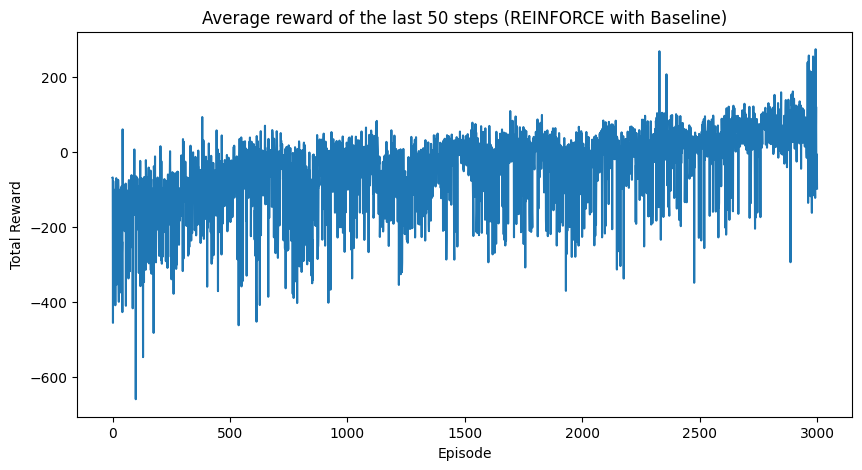

In [23]:
num_episodes = 3000
max_steps = 1000
trained_agent, episode_rewards = train(num_episodes, max_steps)

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards)
plt.title("Average reward of the last 50 steps (REINFORCE with Baseline)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

Play with the visualization! How does your agent perform now?

In [26]:
visualize_policy(trained_agent)

Episode 1, Total Reward: 258.26
Episode 2, Total Reward: -125.37
Episode 3, Total Reward: 8.09
Episode 4, Total Reward: 78.53
Episode 5, Total Reward: 153.21


: 

It performs better than the REINFORCE without baseline, especially from the stableness perspective. On the contrary, it takes longer to converge.

4. How does this method compare to the VPG? Is it better? If so, in what way? Can you think of a way to improve even further?

In terms of the performance, it performs better than the VPG. From the stability perspective, it's more stable than the REINFORCE without baseline. However, it takes longer to converge. I think the possible reason is that the policy network and value network are optimized alternatively in the training process, which may take longer to converge.

As for the improvement, I think there are several directions:
1. Use better baselines, like the Q-value function.
2. Switch to the actor-critic framework.
3. Use A3C or other multi-agent frameworks to optimize the policy and value functions.

## Theory

We have explored basic policy gradient methods, and we have empirically showed that the methods work in some settings. However, do we have some theoretical results about policy gradient? YES! We will be proving the following lemma.

**Performance Difference Lemma**

Consider an infinite horizon MDP $\mathcal{M} = \{\mathcal{S},\mathcal{A},r,P,\gamma\}$. Consider any two policies $\pi,\pi':\mathcal{S}\to\Delta(\mathcal{A})$. Then, for any state $s_0\in\mathcal{S}$, we have
$$V^{\pi}(s_0)-V^{\pi'}(s_0) = \frac{1}{1-\gamma}\mathbb{E}_{s\sim d^{\pi}_{s_0}}\left[\mathbb{E}_{a\sim\pi(\cdot|s)}A^{\pi'}(s,a)\right].$$
where 
- $A^{\pi'}(s,a) = Q^{\pi'}(s,a)-V^{\pi'}(s)$
- $P_h^\pi(s,a;s_0)$ is the probability of $\pi$ reaching (s,a) at time step $h$ starting at $s_0$.
- $P_h^\pi(s;s_0) = \sum_a P_h^\pi(s,a;s_0)$.
- $d^{\pi}_{s_0}(s,a)\coloneqq(1-\gamma)\sum_{h=0}^\infty\gamma^h P_h^\pi(s,a;s_0)$ (state-action visitation distribution)

The lemma is widely used to analyze the convergence of on-policy methods!

### Questions
1. Prove that $d^{\pi}_{s_0}(s,a)$ is a probability distribution.

Now, instead of proving the infinite horizon case, we will be proving a finite horizon MDP $\mathcal{M} = \{\mathcal{S},\mathcal{A},r,P,H,s_0\}$.\
In finite horizon case, the PDL becomes following:\
Consider a finite horizon MDP $\mathcal{M} = \{\mathcal{S},\mathcal{A},r,P,H,s_0\}$. Consider any two policies $\pi,\pi':\mathcal{S}\to\Delta(\mathcal{A})$. Then, for any state $s_0\in\mathcal{S}$, we have
$$V^{\pi}(s_0)-V^{\pi'}(s_0) = \sum_{h=0}^{H-1}\left[\mathbb{E}_{s_h,a_h\sim P_h^\pi(\cdot,\cdot;s_0)}A^{\pi'}(s,a)\right],$$

Note that in a finite horizon case, we do not have convergence issue. So we will not be considering the discount factor. i.e. set $\gamma=1$.

2. Note that we need some adjustments to the state-action visitation distribution. How would you define the state-action visitation distribution in finite horizon MDP?\
(You will need to show two things to prove what you suggest is a probability distribution: 1. non-negativity and 2. sums up to 1 over the support).
3. Prove the PDL for finite horizon MDP

### Q1: Prove that $d^{\pi}_{s_0}(s,a)$ is a probability distribution.

We need to show that $d_{s_0}^\pi(s,a) := (1-\gamma)\sum_{h=0}^\infty \gamma^h P_h^\pi(s,a;s_0)$ is a probability distribution.

#### 1. Non-negativity

First, let's prove that $d_{s_0}^\pi(s,a) \geq 0$ for all $(s,a)$.

- $\gamma \in [0,1)$, so $(1-\gamma) > 0$
- $P_h^\pi(s,a;s_0) \geq 0$ for all $h, s, a, s_0$ (as it's a probability)
- $\gamma^h \geq 0$ for all $h \geq 0$

Therefore, each term in the sum is non-negative, and the sum of non-negative terms is non-negative. Thus, $d_{s_0}^\pi(s,a) \geq 0$ for all $(s,a)$.

#### 2. Sums to 1 over its support

Now, let's prove that $\sum_{s,a} d_{s_0}^\pi(s,a) = 1$.

$$
\begin{aligned}
\sum_{s,a} d_{s_0}^\pi(s,a) &= \sum_{s,a} (1-\gamma)\sum_{h=0}^\infty\gamma^h P_h^\pi(s,a;s_0) \\
&= (1-\gamma)\sum_{h=0}^\infty\gamma^h \sum_{s,a} P_h^\pi(s,a;s_0) \\
&= (1-\gamma)\sum_{h=0}^\infty\gamma^h \cdot 1 \quad \text{(since } \sum_{s,a} P_h^\pi(s,a;s_0) = 1 \text{ for any } h\text{)} \\
&= (1-\gamma)\sum_{h=0}^\infty\gamma^h \\
&= (1-\gamma) \cdot \frac{1}{1-\gamma} \quad \text{(sum of geometric series)} \\
&= 1
\end{aligned}
$$

Therefore, $d_{s_0}^\pi(s,a)$ sums to 1 over all $(s,a)$.

Since $d_{s_0}^\pi(s,a)$ satisfies both non-negativity and sums to 1 over its support, we have proven that it is indeed a probability distribution.

### Q2: Note that we need some adjustments to the state-action visitation distribution. How would you define the state-action visitation distribution in finite horizon MDP? (You will need to show two things to prove what you suggest is a probability distribution: 1. non-negativity and 2. sums up to 1 over the support).

Let's define the state-action visitation distribution for a finite horizon MDP with horizon H as:

$$d_{s_0}^\pi(s,a) := \frac{1}{H} \sum_{h=0}^{H-1} P_h^\pi(s,a;s_0)$$

To prove that this is a probability distribution, we need to show two things:

#### 1. Non-negativity

$d_{s_0}^\pi(s,a) \geq 0$ for all $(s,a)$ because:
- $\frac{1}{H} > 0$ (since H is a positive integer)
- $P_h^\pi(s,a;s_0) \geq 0$ for all $h, s, a, s_0$ (as it's a probability)
- The sum of non-negative terms is non-negative

#### 2. Sums to 1 over its support

Let's prove that $\sum_{s,a} d_{s_0}^\pi(s,a) = 1$:

$$
\begin{aligned}
\sum_{s,a} d_{s_0}^\pi(s,a) &= \sum_{s,a} \frac{1}{H} \sum_{h=0}^{H-1} P_h^\pi(s,a;s_0) \\
&= \frac{1}{H} \sum_{h=0}^{H-1} \sum_{s,a} P_h^\pi(s,a;s_0) \\
&= \frac{1}{H} \sum_{h=0}^{H-1} 1 \quad \text{(since } \sum_{s,a} P_h^\pi(s,a;s_0) = 1 \text{ for any } h\text{)} \\
&= \frac{1}{H} \cdot H \\
&= 1
\end{aligned}
$$

Therefore, $d_{s_0}^\pi(s,a)$ sums to 1 over all $(s,a)$.

Since $d_{s_0}^\pi(s,a)$ satisfies both non-negativity and sums to 1 over its support, we have proven that it is indeed a probability distribution for the finite horizon case.

### Q3: Prove the PDL for finite horizon MDP

Consider a finite horizon MDP $\mathcal{M} = \{\mathcal{S},\mathcal{A},r,P,H,s_0\}$. Consider any two policies $\pi,\pi':\mathcal{S}\to\Delta(\mathcal{A})$. Then, for any state $s_0\in\mathcal{S}$, we have:

$$V^{\pi}(s_0)-V^{\pi'}(s_0) = \sum_{h=0}^{H-1}\left[\mathbb{E}_{s_h,a_h\sim P_h^\pi(\cdot,\cdot;s_0)}A^{\pi'}(s_h,a_h)\right]$$

Where $A^{\pi'}(s,a) = Q^{\pi'}(s,a) - V^{\pi'}(s)$ is the advantage function under policy $\pi'$.

Proof:

1) We start by expanding $V^{\pi}(s_0)$ using the definition of value function:

   $$V^{\pi}(s_0) = \mathbb{E}_{a_0\sim\pi(\cdot|s_0)}\left[r(s_0,a_0) + \mathbb{E}_{s_1\sim P(\cdot|s_0,a_0)}V^{\pi}(s_1)\right]$$

2) Then, we can subtract $V^{\pi'}(s_0)$ from both sides:

   $$V^{\pi}(s_0) - V^{\pi'}(s_0) = \mathbb{E}_{a_0\sim\pi(\cdot|s_0)}\left[r(s_0,a_0) + \mathbb{E}_{s_1\sim P(\cdot|s_0,a_0)}V^{\pi}(s_1)\right] - V^{\pi'}(s_0)$$

3) We can add and subtract $\mathbb{E}_{a_0\sim\pi(\cdot|s_0)}\mathbb{E}_{s_1\sim P(\cdot|s_0,a_0)}V^{\pi'}(s_1)$ to the right-hand side:

   $$\begin{aligned}
   V^{\pi}(s_0) - V^{\pi'}(s_0) = &\mathbb{E}_{a_0\sim\pi(\cdot|s_0)}\left[r(s_0,a_0) + \mathbb{E}_{s_1\sim P(\cdot|s_0,a_0)}V^{\pi'}(s_1)\right] - V^{\pi'}(s_0) \\
   &+ \mathbb{E}_{a_0\sim\pi(\cdot|s_0)}\mathbb{E}_{s_1\sim P(\cdot|s_0,a_0)}\left[V^{\pi}(s_1) - V^{\pi'}(s_1)\right]
   \end{aligned}$$

4) The first two terms on the right-hand side can be rewritten using the definition of $Q^{\pi'}$:

   $$\begin{aligned}
   V^{\pi}(s_0) - V^{\pi'}(s_0) = &\mathbb{E}_{a_0\sim\pi(\cdot|s_0)}\left[Q^{\pi'}(s_0,a_0) - V^{\pi'}(s_0)\right] \\
   &+ \mathbb{E}_{a_0\sim\pi(\cdot|s_0)}\mathbb{E}_{s_1\sim P(\cdot|s_0,a_0)}\left[V^{\pi}(s_1) - V^{\pi'}(s_1)\right]
   \end{aligned}$$

5) We can recognize the advantage function $A^{\pi'}(s_0,a_0) = Q^{\pi'}(s_0,a_0) - V^{\pi'}(s_0)$ in the first term:

   $$V^{\pi}(s_0) - V^{\pi'}(s_0) = \mathbb{E}_{a_0\sim\pi(\cdot|s_0)}\left[A^{\pi'}(s_0,a_0)\right] + \mathbb{E}_{s_1\sim P_1^\pi(\cdot;s_0)}\left[V^{\pi}(s_1) - V^{\pi'}(s_1)\right]$$

6) We can repeat this process for $s_1, s_2, ..., s_{H-1}$. For the finite horizon case, this process terminates after H steps:

   $$\begin{aligned}
   V^{\pi}(s_0) - V^{\pi'}(s_0) = &\mathbb{E}_{a_0\sim\pi(\cdot|s_0)}\left[A^{\pi'}(s_0,a_0)\right] \\
   &+ \mathbb{E}_{s_1,a_1\sim P_1^\pi(\cdot,\cdot;s_0)}\left[A^{\pi'}(s_1,a_1)\right] \\
   &+ \mathbb{E}_{s_2,a_2\sim P_2^\pi(\cdot,\cdot;s_0)}\left[A^{\pi'}(s_2,a_2)\right] \\
   &+ ... \\
   &+ \mathbb{E}_{s_{H-1},a_{H-1}\sim P_{H-1}^\pi(\cdot,\cdot;s_0)}\left[A^{\pi'}(s_{H-1},a_{H-1})\right]
   \end{aligned}$$

7) This can be written more compactly as:

   $$V^{\pi}(s_0)-V^{\pi'}(s_0) = \sum_{h=0}^{H-1}\left[\mathbb{E}_{s_h,a_h\sim P_h^\pi(\cdot,\cdot;s_0)}A^{\pi'}(s_h,a_h)\right]$$

Thus, we have proven the Performance Difference Lemma for the finite horizon case.

### Appendix: Sketch of the proof for infinite horizon case

Note that the proof is very similar to the infinite horizon case, except that we need to sum over the horizon H instead of infinity. Here is the sketch of the proof:

$$\begin{aligned}
& V^\pi\left(s_0\right)-V^{\pi^{\prime}}\left(s_0\right) \\
& =V^\pi\left(s_0\right)-\mathbb{E}_{a_0 \sim \pi\left(\mid s_0\right)}\left[r\left(s_0, a_0\right)+\gamma \mathbb{E}_{s^{\prime} \sim P\left(s_0, a_0\right)} V^{\pi^{\prime}}\left(s^{\prime}\right)\right]+\mathbb{E}_{a_0 \sim \pi\left(\cdot \mid s_0\right)}\left[r\left(s_0, a_0\right)+\gamma \mathbb{E}_{s^{\prime}} \sim P\left(s_0, a_0\right) V^{\pi^{\prime}}\left(s^{\prime}\right)\right]-V^{\pi^{\prime}}\left(s_0\right) \\
& =\mathbb{E}_{a_0 \sim \pi\left(\mid \cdot s_0\right)}\left[r\left(s_0, a_0\right)+\gamma \mathbb{E}_{s^{\prime} \sim P\left(s_0, a_0\right)} V^\pi\left(s^{\prime}\right)\right]-\mathbb{E}_{a_0 \sim \pi\left(\cdot \mid s_0\right)}\left[r\left(s_0, a_0\right)+\gamma \mathbb{E}_{s^{\prime} \sim P\left(s_0, a_0\right)} V^{\pi^{\prime}}\left(s^{\prime}\right)\right] \\
& +\mathbb{E}_{a_0 \sim \pi\left(|\cdot| s_0\right)}\left[r\left(s_0, a_0\right)+\gamma \mathbb{E}_{s^{\prime} \sim P\left(s_0, a_0\right)} V^{\pi^{\prime}}\left(s^{\prime}\right)\right]-V^{\pi^{\prime}}\left(s_0\right) \\
& =\gamma \mathbb{E}_{a_0 \sim \pi\left(\cdot \mid s_0\right)} \mathbb{E}_{s_1 \sim P\left(s_0, a_0\right)}\left[V^\pi\left(s_1\right)-V^{\pi^{\prime}}\left(s_1\right)\right] \\
& +\mathbb{E}_{a_0 \sim \pi\left(\cdot \mid s_0\right)}\left[r\left(s_0, a_0\right)+\gamma \mathbb{E}_{s^{\prime} \sim P\left(s_0, a_0\right)} V^{\pi^{\prime}}\left(s^{\prime}\right)\right]-V^{\pi^{\prime}}\left(s_0\right) \\
& =\gamma \mathbb{E}_{a_0 \sim \pi\left(\cdot \mid s_0\right)} \mathbb{E}_{s_1 \sim P\left(s_0, a_0\right)}\left[V^\pi\left(s_1\right)-V^{\pi^{\prime}}\left(s_1\right)\right]+\mathbb{E}_{a_0 \sim \pi\left(| | s_0\right)}\left[Q^{\pi^{\prime}}\left(s_0, a_0\right)-V^{\pi^{\prime}}\left(s_0\right)\right] \\
& =\underbrace{\gamma \mathbb{E}_{a_0 \sim \pi\left(| | s_0\right)} \mathbb{E}_{s_1 \sim P\left(s_0, a_0\right)}\left[V^\pi\left(s_1\right)-V^{\pi^{\prime}}\left(s_1\right)\right]}_{\text {term a }}+\mathbb{E}_{a_0 \sim \pi\left(| | s_0\right)}\left[A^{\pi^{\prime}}\left(s_0, a_0\right)\right]
\end{aligned}$$

For term a, note that by Markovian property, $\mathbb{P}^\pi (s_1; s_0) = \sum_{a_0} \pi(a_0|s_0)P(s_1|s_0, a_0) = \mathbb{E}_{a_0\sim\pi(\cdot|s_0)}P(s_1|s_0, a_0)$,
we can apply the same operation (i.e., recursion) for the term $V^\pi(s_1) - V^{\pi'}(s_1)$, we have:

$$\begin{aligned}
\text{term a} &= \gamma\mathbb{E}_{s_1\sim\mathbb{P}_1^\pi(\cdot;s_0)} \left[V^\pi(s_1) - V^{\pi'}(s_1)\right] \\
&= \gamma\mathbb{E}_{s_1\sim\mathbb{P}_1^\pi(\cdot;s_0)} \left[\gamma\mathbb{E}_{a_1\sim\pi(\cdot|s_1)}\mathbb{E}_{s_2\sim P(s_1,a_1)} \left[V^\pi(s_2) - V^{\pi'}(s_2)\right] + \mathbb{E}_{a_1\sim\pi(\cdot|s_1)}A^{\pi'}(s_1, a_1)\right] \\
&= \gamma^2\mathbb{E}_{s_2\sim\mathbb{P}_2^\pi(\cdot;s_0)} \left[V^\pi(s_2) - V^{\pi'}(s_2)\right] + \gamma\mathbb{E}_{s_1,a_1\sim\mathbb{P}_1^\pi(\cdot,\cdot;s_0)}A^{\pi'}(s_1, a_1)
\end{aligned}$$

where last step we use the Markovian property again, i.e., $\mathbb{P}_2^\pi(s; s_0) = \sum_{s_1,a_1} \mathbb{P}_1^\pi(s_1; s_0)\pi(a_1|s_1)P(s|s_1, a_1)$. Note
that at this stage, we can apply the same operation (i.e., recursion) to the term $V^\pi(s_2) - V^{\pi'}(s_2)$.

Now combine the above derivations, and repeat the recursion step for infinitely many times, we get:

$$\begin{aligned}
V^\pi(s_0) - V^{\pi'}(s_0) 
&= \mathbb{E}_{a_0\sim\pi(\cdot|s_0)}A^{\pi'}(s_0, a_0) + \gamma\mathbb{E}_{s_1,a_1\sim\mathbb{P}_1^\pi(\cdot,\cdot;s_0)}A^{\pi'}(s_1, a_1) + \gamma^2\mathbb{E}_{s_2\sim\mathbb{P}_2^\pi(\cdot;s_0)}[V^\pi(s_2) - V^{\pi'}(s_2)] \\
&\cdots \\
&= \sum_{h=0}^{\infty}\gamma^h\mathbb{E}_{s,a\sim\mathbb{P}_h^\pi(\cdot,\cdot;s_0)}A^{\pi'}(s, a) \\
&= \frac{1}{1-\gamma}\mathbb{E}_{s,a\sim d_{s_0}^\pi}A^{\pi'}(s, a).
\end{aligned}$$